### Unconditional density estmation
An example of unconditional density estimation with various flow architectures, using the "two moons" distribution.

### Imports

In [1]:
import jax.numpy as jnp
from jax import random
from flowjax.flows import MaskedAutoregressiveFlow, CouplingFlow, TriangularSplineFlow
from flowjax.transformers import (
    AffineTransformer,
    RationalQuadraticSplineTransformer,
)
from flowjax.train_utils import train_flow
from flowjax.distributions import Normal
import matplotlib.pyplot as plt
from sklearn import datasets, preprocessing

### Generate data

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


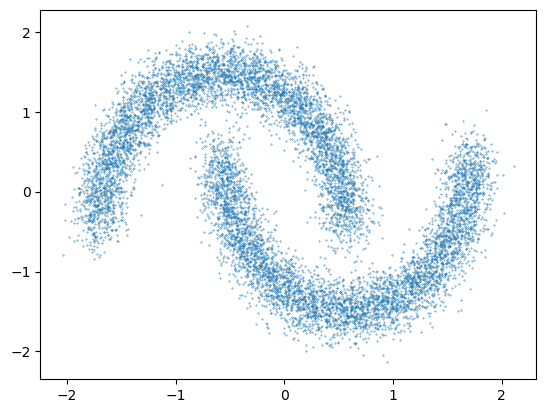

In [2]:
n_samples = 10000
x, _ = datasets.make_moons(n_samples=n_samples, noise=0.1)
x = preprocessing.StandardScaler().fit_transform(x)
x = jnp.array(x)
plt.scatter(x[:, 0], x[:, 1], s=0.1)

### Create flows
Here we show how to create flows including two of the most common architectures, coupling flows (see e.g. [RealNVP](https://arxiv.org/abs/1605.08803)), and [masked autoregressive flows](https://arxiv.org/abs/1705.07057). Here we use `AffineTransformer` and [`RationalQuadraticSplineTransformer`](https://arxiv.org/abs/1906.04032) transformers.

In [3]:
key, flow_key = random.split(random.PRNGKey(0))

flows = {
    "Affine Coupling": CouplingFlow(
        flow_key,
        Normal(jnp.zeros(x.shape[1])),
        AffineTransformer(),
    ),
    "Spline Coupling": CouplingFlow(
        flow_key,
        Normal(jnp.zeros(x.shape[1])),
        RationalQuadraticSplineTransformer(K=8, B=3),
    ),
    "Affine Masked Autoregressive": MaskedAutoregressiveFlow(
        flow_key, Normal(jnp.zeros(x.shape[1])), AffineTransformer()
    ),
    "Spline Masked Autoregressive": MaskedAutoregressiveFlow(
        flow_key,
        Normal(jnp.zeros(x.shape[1])),
        RationalQuadraticSplineTransformer(K=8, B=3),
    ),
    "Triangular Spline": TriangularSplineFlow(
        flow_key,
        Normal(jnp.zeros(x.shape[1])),
    ),
}

### Train and plot results

 94%|█████████▍| 47/50 [00:25<00:01,  1.88it/s, train=1.89, val=1.92 (Max patience reached).]


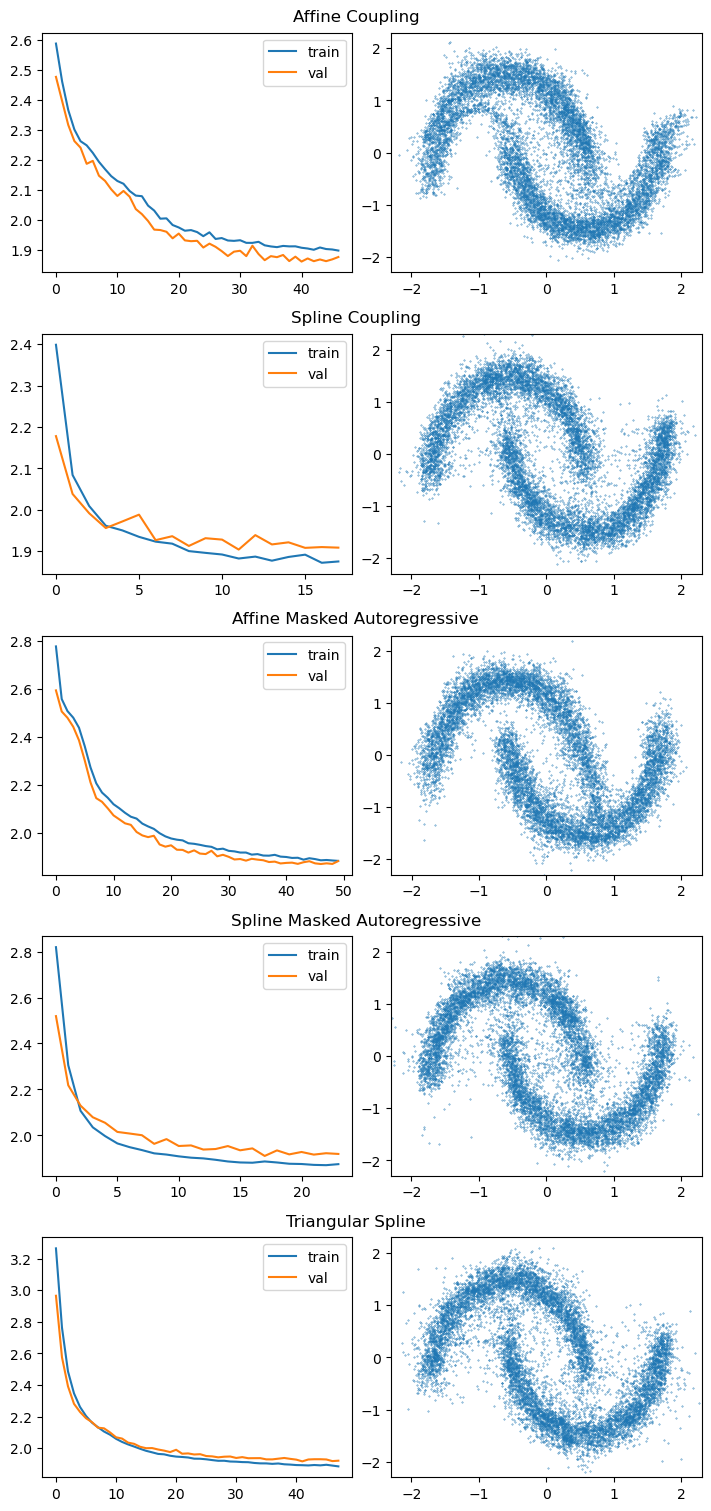

In [4]:
fig = plt.figure(constrained_layout=True)
subfigs = fig.subfigures(nrows=len(flows))

for (name, flow), subfig in zip(flows.items(), subfigs):
    key, subkey = random.split(key)
    flow, losses = train_flow(subkey, flow, x, learning_rate=1e-3)

    key, subkey = random.split(key)
    x_samples = flow.sample(key, n=10000)

    subfig.suptitle(name)

    ax1, ax2 = subfig.subplots(ncols=2)

    for k, v in losses.items():
        ax1.plot(v, label=k)
    ax1.legend()

    ax2.scatter(x_samples[:, 0], x_samples[:, 1], s=0.1)
    lims = (-2.3, 2.3)
    ax2.set_xlim(*lims)
    ax2.set_ylim(*lims)

fig.set_size_inches(7, 15)
plt.show()

### Density estimation
We can evaluate the probability of arbitrary points

In [5]:
five_points = jnp.linspace(0, 1, num=10).reshape((5, 2))
flow.log_prob(five_points)

Array([-4.4164295, -3.3467624, -1.180084 , -4.5497017, -5.909316 ],      dtype=float32)

### Accessing the bijection
We can access the bijection and transform specific points if desired.

In [6]:
x = jnp.ones(2)
y = flow.bijection.transform(
    x
)  # Batching not supported for bijections - use jax.vmap if required!
x_reconstructed = flow.bijection.inverse(y)
print("Original ", x)
print("Transformed", y)
print("Inverted", x_reconstructed)

Original  [1. 1.]
Transformed [-0.6152371  1.7017508]
Inverted [0.99999434 0.9999972 ]
